Загружаем данные о графе

In [53]:
!wget https://snap.stanford.edu/data/wiki-Vote.txt.gz
!gzip -d ./wiki-Vote.txt.gz

--2024-04-23 14:06:51--  https://snap.stanford.edu/data/wiki-Vote.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 290339 (284K) [application/x-gzip]
Saving to: ‘wiki-Vote.txt.gz’

wiki-Vote.txt.gz    100%[===================>] 283.53K   133KB/s    in 2.1s    

2024-04-23 14:06:55 (133 KB/s) - ‘wiki-Vote.txt.gz’ saved [290339/290339]



In [2]:
!git clone https://github.com/OafishSpark/InfluencerSearchAlgorithms

!mv /content/InfluencerSearchAlgorithms/* /content/
!rm -rf /content/InfluencerSearchAlgorithms

Cloning into 'InfluencerSearchAlgorithms'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 96 (delta 40), reused 84 (delta 28), pack-reused 0
Receiving objects: 100% (96/96), 16.10 KiB | 1.46 MiB/s, done.
Resolving deltas: 100% (40/40), done.
mv: cannot stat '/content/InfluencerSearchAlgorithms/*': No such file or directory


In [2]:
import networkx as nx

import numpy as np
from numpy import random

from tqdm import tqdm

In [3]:
from models.threshold_model import linear_threshold_model
from models.sir_model import sir_model, sir_inf_model

from influencers.greedy_kkt import greedy_kkt_influencers
from influencers.centrality import centrality_influencers
from influencers.shapley_value import shapley_value_influencers
from influencers.csr import csr_influencers
from influencers.hierarchy import hierarchy_influencers_dull, hierarchy_influencers_with_csr, hierarchy_influencers_with_centrality

from communities.clustering import clustering_communities
from communities.shapley_value import shapley_value_communities

from communities.hierarchy import hierarchy_communities_original, hierarchy_communities_improved

In [4]:
graph_congress = nx.read_edgelist("./congress_network/congress.edgelist", create_using=nx.DiGraph())

In [54]:
graph_wiki_votes = nx.read_edgelist("./wiki-Vote.txt", create_using=nx.DiGraph())
nx.set_edge_attributes(graph_wiki_votes, 1, 'weight')

In [55]:
subgraph_wiki_votes = nx.subgraph(graph_wiki_votes, list(graph_wiki_votes.nodes)[:100])

In [56]:
graphs = {
  "graph congress": graph_congress,
  "graph wiki votes": subgraph_wiki_votes,
}

In [57]:
for name in graphs.keys():
  print(name)
  graph = graphs[name]
  print(graph.number_of_nodes())
  print(graph.number_of_edges())
  print(nx.density(graph))
  print(nx.number_strongly_connected_components(graph))
  print("")

graph congress
475
13289
0.05902287363979569
7

graph wiki votes
100
985
0.0994949494949495
40



In [58]:
graph = graphs["graph wiki votes"]
# graph = graph_congress

Communities

In [59]:
communities = {
    "communities shapley": shapley_value_communities(graph, 10),
    "communities clusters": clustering_communities(graph, 10),
    "communities hierarchy original": hierarchy_communities_original(graph, 10),
    "communities hierarchy improved": hierarchy_communities_improved(graph, 10)
}

Influencers

In [60]:
influencers_pack = {
    "influencers hierarchy with centrality": hierarchy_influencers_with_centrality(graph, 10),
    "influencers shapley": shapley_value_influencers(graph, 10),
    "influencers centrality": centrality_influencers(graph, 10),
    "influencers kkt": greedy_kkt_influencers(graph, 10),
    "influencers hierarchy orig": hierarchy_influencers_dull(graph, 10),
    "influencers hierarchy improved": hierarchy_influencers_with_csr(graph, 10),
}

In [61]:
influencers_csr = dict(zip(
    ['csr ' + name for name in communities.keys()],
    [csr_influencers(graph, 10, community) for community in communities.values()]
))

In [62]:
influencers_pack.update(influencers_csr)

In [63]:
def perform_experiment(
    n_experiments: int,
    graph: nx.DiGraph,
    influencers_dict: dict,
    time: int = 5,
) -> dict:
  nodes = list(graph.nodes)
  n_nodes = len(nodes)
  results = dict(zip(
    ["linear threshold model", "SIR model", "Infinite SIR model"],
    [dict([(name, 0) for name in influencers_dict.keys()]) for _ in range(3)]
  ))
  for _ in tqdm(range(n_experiments)):
    theta = dict(zip(list(graph.nodes), random.uniform(0.01, 0.99, graph.number_of_nodes())))
    # infection_prob = dict(zip(nodes, random.uniform(0.01, 0.99, n_nodes)))
    # recover_prob = dict(zip(nodes, random.uniform(0.01, 0.99, n_nodes)))
    for name in influencers_dict.keys():
      influencers = influencers_dict[name]
      results['linear threshold model'][name] += len(linear_threshold_model(graph, influencers, time, theta)) / n_experiments
      results['SIR model'][name] += len(sir_model(graph, influencers, time)) / n_experiments
  for name in influencers_dict.keys():
    influencers = influencers_dict[name]
    results['Infinite SIR model'][name] += len(sir_inf_model(graph, influencers, time))
  return results

In [64]:
number_of_experiments = 10

In [66]:
times = [8*i + 1 for i in range(5)]
results = dict(zip(
    times,
    [perform_experiment(number_of_experiments, graph, influencers_pack, time) for time in times]
))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


In [67]:
times

[1, 9, 17, 25, 33]

In [80]:
results

{1: {'linear threshold model': {'influencers hierarchy with centrality': 29.7,
   'influencers shapley': 17.5,
   'influencers centrality': 42.49999999999999,
   'influencers kkt': 26.299999999999997,
   'influencers hierarchy orig': 35.99999999999999,
   'influencers hierarchy improved': 23.700000000000003,
   'csr communities shapley': 10.0,
   'csr communities clusters': 10.0,
   'csr communities hierarchy original': 10.0,
   'csr communities hierarchy improved': 42.1},
  'SIR model': {'influencers hierarchy with centrality': 60.4,
   'influencers shapley': 32.800000000000004,
   'influencers centrality': 83.90000000000002,
   'influencers kkt': 56.800000000000004,
   'influencers hierarchy orig': 78.1,
   'influencers hierarchy improved': 46.7,
   'csr communities shapley': 10.0,
   'csr communities clusters': 10.0,
   'csr communities hierarchy original': 10.0,
   'csr communities hierarchy improved': 80.3},
  'Infinite SIR model': {'influencers hierarchy with centrality': 100,
  

In [81]:
for results_t in results.values():
    for model in results_t.keys():
      print(model + ":")
      for infl_alg in sorted(results_t[model], reverse=True, key=lambda x: results_t[model][x])[:5]:
        print(infl_alg + ": " + str(results_t[model][infl_alg]))
      print('\n')

linear threshold model:
influencers centrality: 42.49999999999999
csr communities hierarchy improved: 42.1
influencers hierarchy orig: 35.99999999999999
influencers hierarchy with centrality: 29.7
influencers kkt: 26.299999999999997


SIR model:
influencers centrality: 83.90000000000002
csr communities hierarchy improved: 80.3
influencers hierarchy orig: 78.1
influencers hierarchy with centrality: 60.4
influencers kkt: 56.800000000000004


Infinite SIR model:
influencers hierarchy with centrality: 100
influencers hierarchy orig: 97
influencers centrality: 95
influencers hierarchy improved: 95
csr communities hierarchy improved: 93


linear threshold model:
influencers centrality: 95.4
influencers hierarchy orig: 94.2
csr communities hierarchy improved: 93.5
influencers hierarchy with centrality: 76.4
influencers kkt: 73.20000000000002


SIR model:
influencers hierarchy with centrality: 100.0
influencers kkt: 100.0
influencers hierarchy improved: 100.0
csr communities hierarchy improved

In [26]:
import matplotlib.pyplot as plt
from copy import deepcopy

In [78]:
inner_lists = {
    "influencers hierarchy with centrality": [],
    "influencers kkt" : [],
    "influencers shapley": [],
    "influencers centrality": [],
    "influencers kkt": [],
    "influencers hierarchy orig": [],
    "influencers hierarchy improved": [],
    "csr communities shapley": [],
    "csr communities clusters": [],
    "csr communities hierarchy original": [],
    "csr communities hierarchy improved": [],
}

results_lists = {
    "linear threshold model": inner_lists,
    "SIR model": deepcopy(inner_lists),
    "Infinite SIR model": deepcopy(inner_lists),
}

for t in times:
    for model in results[t].keys():
        for key in results[t][model].keys():
            results_lists[model][key].append(results[t][model][key])

In [79]:
results_lists['linear threshold model']['csr communities hierarchy original']

[10.0, 10.0, 10.0, 10.0, 10.0]

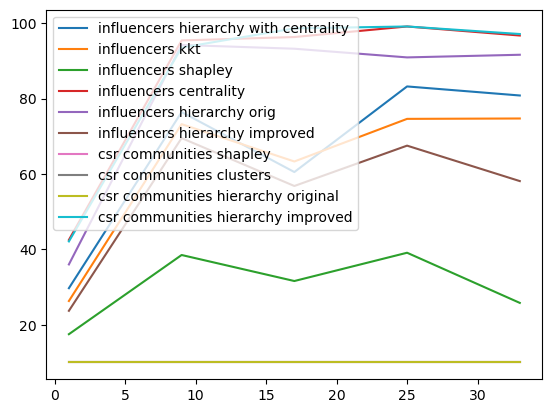

In [74]:
fig, ax = plt.subplots()

for key in results_lists["linear threshold model"]:
    ax.plot(times, results_lists["linear threshold model"][key], label = key)

plt.legend(loc='upper left')

plt.show()

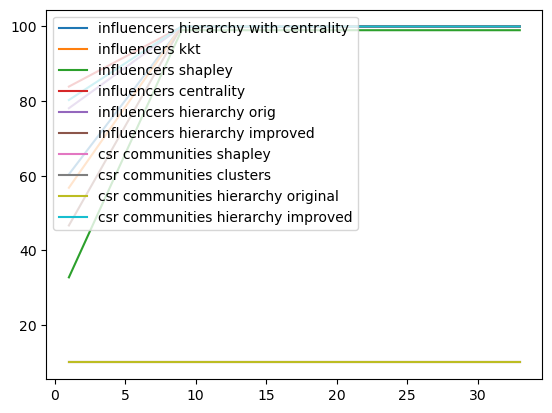

In [75]:
fig, ax = plt.subplots()

for key in results_lists["SIR model"]:
    ax.plot(times, results_lists["SIR model"][key], label = key)

plt.legend(loc='upper left')

plt.show()

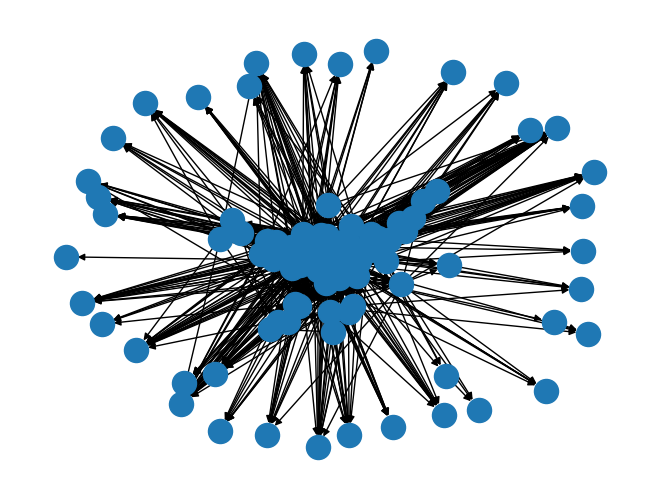

In [82]:
nx.draw(graph)